In [3]:
# Importamos todas las librerías que necesitaremos
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
#df_modelo = pd.read_csv('df_eda_limpio.csv')
#df_modelo.head()

In [4]:
# Obtener el directorio actual de trabajo (el directorio donde está el script)
current_directory = os.getcwd()

# Crear la ruta relativa a 'Modelo/df_modelo_limpio.csv' desde 'Pruebas_Modelo'
file_path = os.path.join(current_directory, '..', 'Modelo', 'df_modelo_limpio.csv')

# Verificar si la ruta es correcta
# print(file_path)

# Leer el archivo CSV
df_modelo = pd.read_csv(file_path)

# Mostrar las primeras filas del DataFrame
df_modelo.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_name,...,vehicle_age,price_per_power,price_per_year,dealer_info,power_per_kms,make_popularity,model_popularity,big_city_dealer,price_range,normalized_version
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5.0,110.0,manual,22900,Sergio Y.,...,3,208.19,7633.34,"Sergio Y.\r\n2, Carrer de Jacint Benavente, Po...",22.000000,4591,158,0,20-30k,12 gasolina 110 gs 2022
1,Opel,Crossland,1.2 81kW GS Line,Gasolina,2022,24847.0,110.0,manual,19990,Peugeot Alcala 534,...,3,181.73,6663.34,"Peugeot Alcala 534\r\nAvenida de José Gárate, ...",0.004427,4591,158,0,10-20k,12gs 2022
2,Opel,Crossland,1.5D 88kW Business Elegance Auto,Diésel,2021,41356.0,120.0,automatic,18590,Clicars S.,...,4,154.92,4647.50,"Clicars S.\r\nSan Cristóbal, Avenida de Andalu...",0.002902,4591,158,1,10-20k,15dbusiness elegance 2021
3,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S,Gasolina,2022,11.0,110.0,manual,22700,Vallescar S.,...,3,206.37,7566.67,"Vallescar S.\r\nParc de Bombers de Sabadell, 5...",10.000000,4591,158,0,20-30k,12 gasolina 2022
4,Opel,Crossland,1.2 GS LINE 5P,Gasolina,2021,51390.0,110.0,manual,18200,onecar.es A.,...,4,165.46,4550.00,"onecar.es A.\r\nCalle de las Bulerías, Cruz de...",0.002140,4591,158,0,10-20k,12 gs line5p 2021


In [5]:
# Eliminar las filas con valores nulos en 'version' directamente en el DataFrame original
df_modelo.dropna(subset=['version'], inplace=True)

In [6]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8915 entries, 0 to 8915
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make                8915 non-null   object 
 1   model               8915 non-null   object 
 2   version             8915 non-null   object 
 3   fuel                8915 non-null   object 
 4   year                8915 non-null   int64  
 5   kms                 8915 non-null   float64
 6   power               8915 non-null   float64
 7   shift               8915 non-null   object 
 8   price               8915 non-null   int64  
 9   dealer_name         8915 non-null   object 
 10  dealer_address      8915 non-null   object 
 11  dealer_city         8915 non-null   object 
 12  dealer_zip_code     8915 non-null   int64  
 13  province            8915 non-null   object 
 14  vehicle_age         8915 non-null   int64  
 15  price_per_power     8915 non-null   float64
 16  price_per_y

In [7]:
# Características originales
features = ['year', 'kms', 'power', 'vehicle_age', 'fuel', 'shift', 'make', 'model']
target = 'price'

# Separamos en variables originales
X = df_modelo[features].copy()
y = df_modelo[target]

In [8]:
# Creamos nuevas características que pueden aportar valor al modelo
# Potencia relativa a la edad (los coches potentes pierden valor más rápido con la edad)
X['power_per_age'] = df_modelo['power'] / (df_modelo['vehicle_age'] + 1)

# Kilometraje anual (un indicador importante del uso del vehículo)
X['km_per_year'] = df_modelo['kms'] / (df_modelo['vehicle_age'] + 1)

# Transformación logarítmica de kilometraje (suaviza valores extremos)
X['log_kms'] = np.log1p(df_modelo['kms'])

# Mostramos las primeras filas de nuestro dataset mejorado
X.head()

,year,kms,power,vehicle_age,fuel,shift,make,model,power_per_age,km_per_year,log_kms
0,2022,5.0,110.0,3,Gasolina,manual,Opel,Crossland,27.5,1.25,1.791759
1,2022,24847.0,110.0,3,Gasolina,manual,Opel,Crossland,27.5,6211.75,10.120533
2,2021,41356.0,120.0,4,Diésel,automatic,Opel,Crossland,24.0,8271.20,10.629997
3,2022,11.0,110.0,3,Gasolina,manual,Opel,Crossland,27.5,2.75,2.484907
4,2021,51390.0,110.0,4,Gasolina,manual,Opel,Crossland,22.0,10278.00,10.847218


In [9]:
# Definimos cuáles son las características numéricas, incluyendo las nuevas
numeric_features = ['year', 'kms', 'power', 'vehicle_age']
numeric_features_extended = numeric_features + ['power_per_age', 'km_per_year', 'log_kms']
categorical_features = ['fuel', 'shift', 'make', 'model']

# Detectamos outliers mediante Z-score
# Calculamos los Z-scores para características numéricas
z_scores = stats.zscore(X[numeric_features_extended])
abs_z_scores = np.abs(z_scores)

# Consideramos outliers valores con Z-score > 3 (muy alejados de la media)
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Filtramos el dataset para eliminar los outliers
X_filtered = X[filtered_entries]
y_filtered = y[filtered_entries]

# Comprobamos cuántos registros se eliminaron
print(f"Registros originales: {len(X)}")
print(f"Registros después de eliminar outliers: {len(X_filtered)}")
print(f"Registros eliminados: {len(X) - len(X_filtered)} ({(len(X) - len(X_filtered))/len(X)*100:.2f}%)")

Registros originales: 8915
Registros después de eliminar outliers: 8567
Registros eliminados: 348 (3.90%)


In [10]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

# Verificamos las dimensiones de los conjuntos
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6853, 11)
X_test shape: (1714, 11)
y_train shape: (6853,)
y_test shape: (1714,)


In [11]:
# Definimos el preprocesador para las características numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        # Estandarizamos variables numéricas (media 0, desviación 1)
        ('num', StandardScaler(), numeric_features_extended),
        # Codificamos variables categóricas con one-hot encoding
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Este preprocesador se aplicará de forma automática en el pipeline

In [12]:
# Definimos varios modelos avanzados con configuraciones iniciales
# RandomForest con mayor número de árboles
rf_model = RandomForestRegressor(
    n_estimators=300,  # Más árboles para mejor generalización
    max_depth=None,    # Permitimos árboles profundos
    min_samples_split=2,
    random_state=42
)

In [13]:
# XGBoost con regularización para evitar sobreajuste
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,  # Tasa de aprendizaje baja para mejor generalización
    max_depth=6,         # Profundidad controlada
    reg_lambda=1.0,      # Regularización L2
    random_state=42
)

In [14]:
# Actualizamos el diccionario de modelos
models = {
    'RandomForest': rf_model,
    'XGBoost': xgb_model
}

In [15]:
# Configuramos la validación cruzada con 5 folds
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Para cada modelo, ejecutamos validación cruzada y guardamos los resultados
for name, model in models.items():
    print(f"Entrenando modelo: {name}")
    
    # Creamos un pipeline que incluye preprocesamiento y modelo
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Almacenamos los scores de cada fold
    scores = []
    
    # Realizamos la validación cruzada
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train)):
        # Separamos los datos para este fold
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # Entrenamos el pipeline
        pipeline.fit(X_train_cv, y_train_cv)
        
        # Evaluamos en el conjunto de validación
        y_pred_cv = pipeline.predict(X_val_cv)
        fold_score = r2_score(y_val_cv, y_pred_cv)
        scores.append(fold_score)
        
        print(f"  Fold {fold+1}: R² = {fold_score:.4f}")
    
    # Calculamos estadísticas de los scores
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"  Media R²: {mean_score:.4f} (±{std_score:.4f})")
    
    # Entrenamos el modelo con todos los datos de entrenamiento
    pipeline.fit(X_train, y_train)
    
    # Guardamos los resultados
    cv_results[name] = {
        'mean_r2': mean_score,
        'std_r2': std_score,
        'pipeline': pipeline
    }
    
    print("-" * 50)

Entrenando modelo: RandomForest
  Fold 1: R² = 0.7521
  Fold 2: R² = 0.7517
  Fold 3: R² = 0.7205
  Fold 4: R² = 0.7555
  Fold 5: R² = 0.7636
  Media R²: 0.7487 (±0.0147)
--------------------------------------------------
Entrenando modelo: XGBoost
  Fold 1: R² = 0.7788
  Fold 2: R² = 0.7714
  Fold 3: R² = 0.7535
  Fold 4: R² = 0.7858
  Fold 5: R² = 0.7858
  Media R²: 0.7750 (±0.0120)
--------------------------------------------------


In [16]:
# Evaluamos cada modelo individualmente en el conjunto de prueba
individual_results = {}

for name, result in cv_results.items():
    pipeline = result['pipeline']
    y_pred = pipeline.predict(X_test)
    
    # Calculamos métricas de rendimiento
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    individual_results[name] = {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"Resultados para {name}:")
    print(f"  RMSE: {rmse:.2f} €")
    print(f"  MAE: {mae:.2f} €")
    print(f"  MAPE: {mape:.4f} %")
    print(f"  R²: {r2:.4f}")
    print("-" * 50)

Resultados para RandomForest:
  RMSE: 4963.90 €
  MAE: 2955.01 €
  MAPE: 1.8687 %
  R²: 0.7356
--------------------------------------------------
Resultados para XGBoost:
  RMSE: 4761.57 €
  MAE: 2868.14 €
  MAPE: 1.8947 %
  R²: 0.7568
--------------------------------------------------


In [17]:
# Creamos un ensemble ponderado basado en el rendimiento en validación cruzada
predictions = {}
weights = {}
total_weight = 0

# Calculamos los pesos basados en el R² de la validación cruzada
for name, result in cv_results.items():
    # Obtenemos las predicciones del modelo para el conjunto de prueba
    predictions[name] = individual_results[name]['predictions']
    
    # Asignamos peso proporcional al R² (mejor rendimiento = mayor peso)
    weights[name] = result['mean_r2']
    total_weight += weights[name]

# Normalizamos los pesos para que sumen 1
for name in weights:
    weights[name] = weights[name] / total_weight
    print(f"Peso asignado a {name}: {weights[name]:.4f}")

# Calculamos la predicción ponderada
weighted_pred = np.zeros_like(y_test, dtype=float)
for name, pred in predictions.items():
    weighted_pred += weights[name] * pred

Peso asignado a RandomForest: 0.4914
Peso asignado a XGBoost: 0.5086


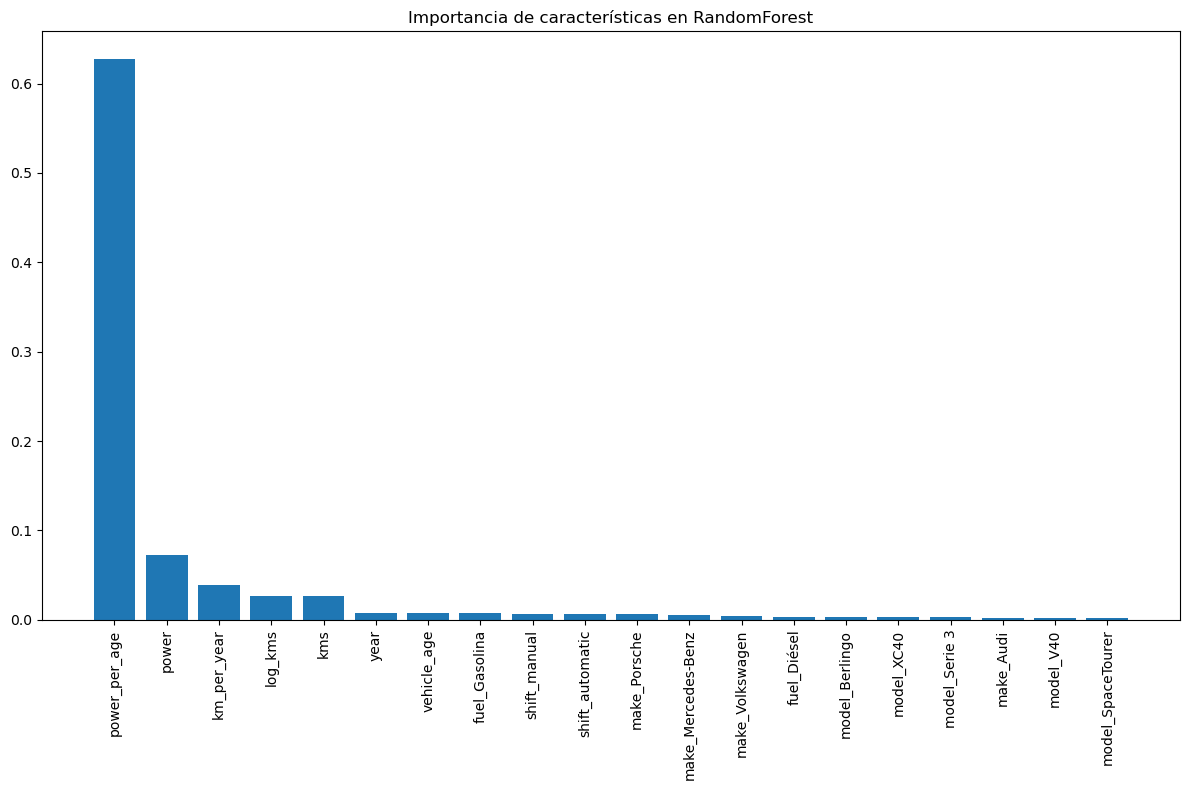

Las 10 características más importantes:
1. power_per_age: 0.6271
2. power: 0.0725
3. km_per_year: 0.0387
4. log_kms: 0.0270
5. kms: 0.0268
6. year: 0.0075
7. vehicle_age: 0.0073
8. fuel_Gasolina: 0.0072
9. shift_manual: 0.0065
10. shift_automatic: 0.0064


In [19]:
# Extraemos la importancia de características del modelo RandomForest
rf_pipeline = cv_results['RandomForest']['pipeline']
rf_model = rf_pipeline.named_steps['model']

# Obtenemos los nombres de las características después del procesamiento
feature_names = (
    numeric_features_extended + 
    list(rf_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

# Obtenemos los valores de importancia
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualizamos las 20 características más importantes
plt.figure(figsize=(12, 8))
plt.title('Importancia de características en RandomForest')
plt.bar(range(min(20, len(importances))), importances[indices[:20]])
plt.xticks(range(min(20, len(importances))), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Imprimimos las 10 características más importantes
print("Las 10 características más importantes:")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

Los 10 casos con mayor error absoluto:
      true_price  predicted_price         error  error_percentage
1407         611     38932.080317  38321.080317       6271.862572
4318        1000     39164.558974  38164.558974       3816.455897
4032         467     36191.829530  35724.829530       7649.856430
3234       44000     15622.676746  28377.323254         64.493916
4387       39900     11550.404939  28349.595061         71.051617
2084         435     27987.066993  27552.066993       6333.808504
1818       44990     17688.388344  27301.611656         60.683733
3142       44999     18085.607494  26913.392506         59.808868
3299         570     27245.917603  26675.917603       4679.985544
2116         372     26329.556031  25957.556031       6977.837643

Los 10 casos con mayor error porcentual:
      true_price  predicted_price         error  error_percentage
6395          20      4641.074405   4621.074405      23105.372026
1631         235     20728.648426  20493.648426       8720.70

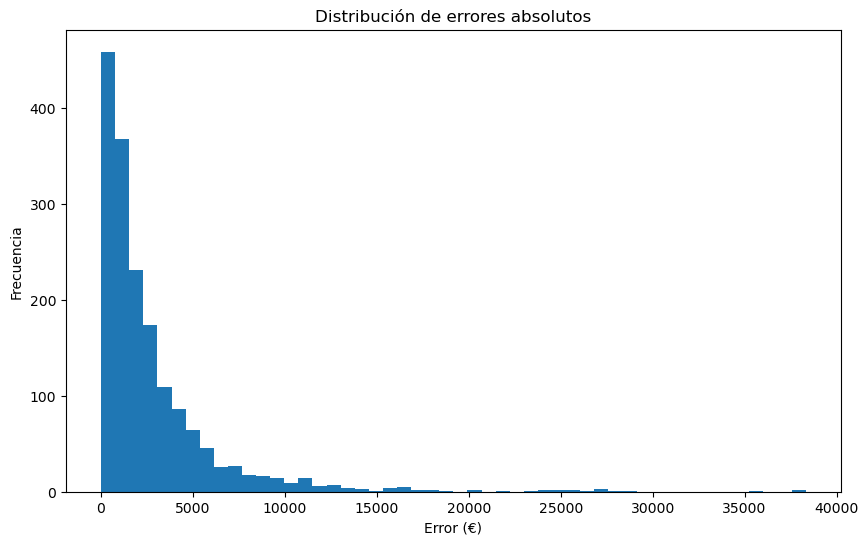

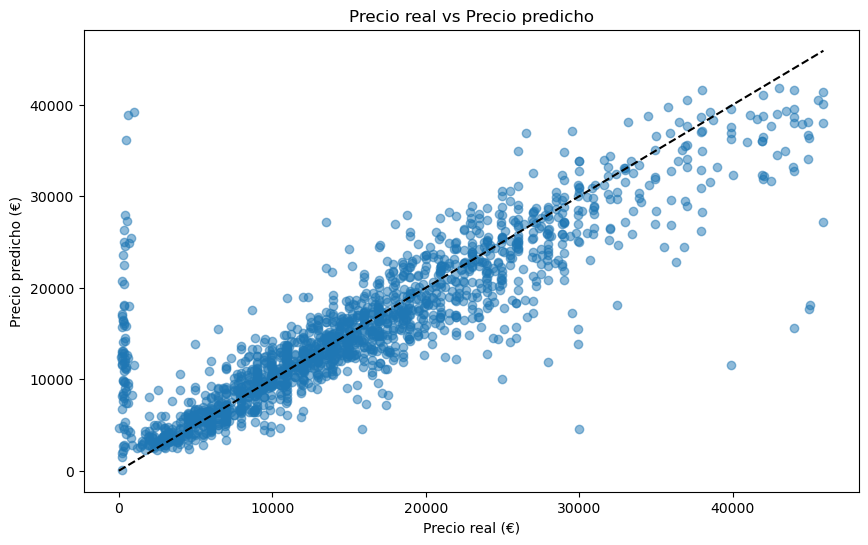

In [20]:
# Analizamos en qué casos el modelo tiene mayor error
errors = np.abs(y_test - weighted_pred)
error_df = pd.DataFrame({
    'true_price': y_test,
    'predicted_price': weighted_pred,
    'error': errors,
    'error_percentage': errors / y_test * 100
})

# Ordenamos por error absoluto
print("Los 10 casos con mayor error absoluto:")
print(error_df.sort_values('error', ascending=False).head(10))

# Ordenamos por error porcentual
print("\nLos 10 casos con mayor error porcentual:")
print(error_df.sort_values('error_percentage', ascending=False).head(10))

# Visualizamos la distribución de errores
plt.figure(figsize=(10, 6))
plt.hist(error_df['error'], bins=50)
plt.title('Distribución de errores absolutos')
plt.xlabel('Error (€)')
plt.ylabel('Frecuencia')
plt.show()

# Visualizamos precio real vs predicción
plt.figure(figsize=(10, 6))
plt.scatter(y_test, weighted_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('Precio real vs Precio predicho')
plt.xlabel('Precio real (€)')
plt.ylabel('Precio predicho (€)')
plt.show()